# Tutorial: optimal binning with continuous target

## Basic

To get us started, let's load a well-known dataset from the UCI repository and transform the data into a ``pandas.DataFrame``.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
class Data:
    def __init__(self, data, target, feature_names):
        self.data = data
        self.target = target
        self.feature_names = feature_names


def load_boston():
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
    raw_data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS',
                     'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

    return Data(raw_data, target, feature_names)

In [3]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

We choose a variable to discretize and the continuous target.

In [4]:
variable = "LSTAT"
x = df[variable].values
y = data.target

Import and instantiate an ``ContinuousOptimalBinning`` object class. We pass the variable name and its data type.

In [5]:
from optbinning import ContinuousOptimalBinning

In [6]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical")

We fit the optimal binning object with arrays ``x`` and ``y``.

In [7]:
optb.fit(x, y)

ContinuousOptimalBinning(name='LSTAT')

You can check if an optimal solution has been found via the ``status`` attribute:

In [8]:
optb.status

'OPTIMAL'

You can also retrieve the optimal split points via the ``splits`` attribute:

In [9]:
optb.splits

array([ 4.6500001 ,  5.49499989,  6.86500001,  9.7249999 , 13.0999999 ,
       14.4000001 , 17.23999977, 19.89999962, 23.31500053])

#### The binning table

The optimal binning algorithms return a binning table; a binning table displays the binned data and several metrics for each bin. Class ``ContinuousOptimalBinning`` returns an object ``ContinuousBinningTable`` via the ``binning_table`` attribute.

In [10]:
binning_table = optb.binning_table

In [11]:
type(binning_table)

optbinning.binning.binning_statistics.ContinuousBinningTable

The `binning_table` is instantiated, but not built. Therefore, the first step is to call the method `build`, which returns a ``pandas.DataFrame``.

In [12]:
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 4.65)",50,0.098814,1985.9,8.198651,39.718000,22.8,50.0,0,17.185194,1.698142
1,"[4.65, 5.49)",28,0.055336,853.2,6.123541,30.471429,21.9,50.0,0,7.938622,0.439291
2,"[5.49, 6.87)",45,0.088933,1188.6,5.136259,26.413333,20.6,48.8,0,3.880527,0.345106
3,"[6.87, 9.72)",89,0.175889,2274.9,6.845250,25.560674,11.9,50.0,0,3.027868,0.532570
4,"[9.72, 13.10)",84,0.166008,1755.4,2.949979,20.897619,14.5,31.0,0,-1.635187,0.271454
5,"[13.10, 14.40)",32,0.063241,667.4,2.632482,20.856250,15.0,29.6,0,-1.676556,0.106027
6,"[14.40, 17.24)",60,0.118577,1037.5,3.588003,17.291667,10.2,30.7,0,-5.241140,0.621479
7,"[17.24, 19.90)",43,0.084980,714.3,4.032554,16.611628,8.3,27.5,0,-5.921178,0.503183
8,"[19.90, 23.32)",28,0.055336,368.4,3.912839,13.157143,5.0,21.7,0,-9.375663,0.518811
9,"[23.32, inf)",47,0.092885,556.0,4.006586,11.829787,5.0,23.7,0,-10.703019,0.994154


Let's describe the columns of this binning table:

- Bin: the intervals delimited by the optimal split points.
- Count: the number of records for each bin.
- Count (%): the percentage of records for each bin.
- Sum: the target sum for each bin.
- Std: the target std for each bin.
- Mean: the target mean for each bin.
- Min: the target min value for each bin.
- Max: the target max value for each bin.
- Zeros count: the number of zeros for each bin.
- WoE: Surrogate Weight-of-Evidence for each bin.
- IV: Surrogate IV for each bin.

The WoE IV for a continuous target is computed as follows:

\begin{equation}
IV = \sum_{i=1}^n \text{WoE}_i \frac{r_i}{r_T}, \quad \text{WoE}_i = |U_i - \mu|,
\end{equation}

where $U_i$ is the target mean value for each bin, $\mu$ is the total target mean, $r_i$ is the number of records for each bin, and $r_T$ is the total number of records.

The last row shows the total number of records, sum and mean.

You can use the method ``plot`` to visualize the histogram and mean curve. Note that the Bin ID corresponds to the binning table index.

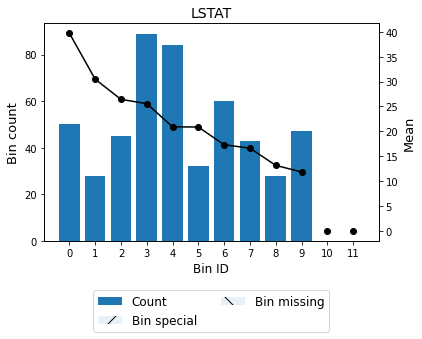

In [13]:
binning_table.plot()

Optionally, you can show the binning plot with the actual bin widths.

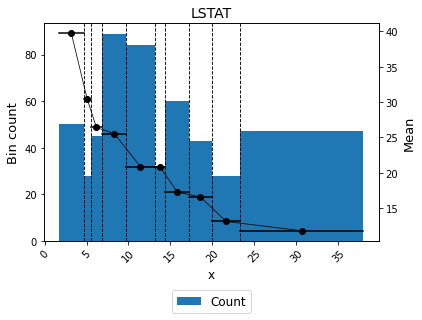

In [14]:
binning_table.plot(style="actual")

Or show the bin labels instead of bin ids.

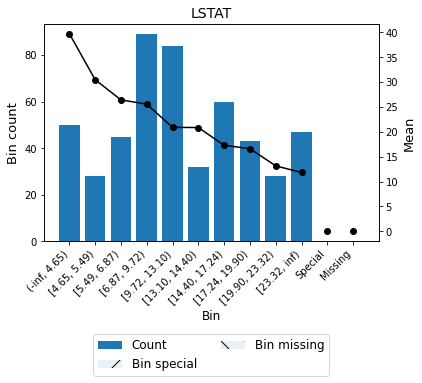

In [15]:
binning_table.plot(show_bin_labels=True)

##### Mean transformation

Now that we have checked the binned data, we can transform our original data into mean values. You can check the correctness of the transformation using pandas ``value_counts`` method, for instance.

In [16]:
x_transform_bins = optb.transform(x, metric="bins")

In [17]:
pd.Series(x_transform_bins).value_counts()

[6.87, 9.72)      89
[9.72, 13.10)     84
[14.40, 17.24)    60
(-inf, 4.65)      50
[23.32, inf)      47
[5.49, 6.87)      45
[17.24, 19.90)    43
[13.10, 14.40)    32
[19.90, 23.32)    28
[4.65, 5.49)      28
dtype: int64

## Advanced

Many of the advanced options have been covered in the previous tutorials with a binary target. **Check it out!** In this section, we focus on the mean monotonicity trend and the mean difference between bins.

#### Binning table statistical analysis

The ``analysis`` method performs a statistical analysis of the binning table, computing the Information Value (IV), Weight of Evidence (WoE), and Herfindahl-Hirschman Index (HHI). Additionally, several statistical significance tests between consecutive bins of the contingency table are performed using the Student's t-test.

In [18]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       6.03021763
    WoE                    111.65056765
    WoE (normalized)         4.95502274
    HHI                      0.11620241
    HHI (normalized)         0.03585717
    Quality score            0.01333978

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1     5.644492 3.313748e-07
        1      2     2.924528 5.175586e-03
        2      3     0.808313 4.206096e-01
        3      4     5.874488 3.816654e-08
        4      5     0.073112 9.419504e-01
        5      6     5.428848 5.770714e-07
        6      7     0.883289 3.796030e-01
        7      8     3.591859 6.692488e-04
        8      9     1.408305 1.643801e-01



#### Mean monotonicity

The monotonic_trend option permits forcing a monotonic trend to the mean curve. The default setting “auto” should be the preferred option, however, some business constraints might require to impose different trends. The default setting “auto” chooses the monotonic trend most likely to minimize the L1-norm from the options “ascending”, “descending”, “peak” and “valley” using a machine-learning-based classifier.

In [19]:
variable = "INDUS"
x = df[variable].values

In [20]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="auto")
optb.fit(x, y)

ContinuousOptimalBinning(name='INDUS')

In [21]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 3.35)",63,0.124506,1994.0,8.569841,31.650794,16.5,50.0,0,9.117987,1.135243
1,"[3.35, 5.04)",57,0.112648,1615.2,8.072710,28.336842,17.2,50.0,0,5.804036,0.653814
2,"[5.04, 6.66)",66,0.130435,1723.7,7.879078,26.116667,16.0,50.0,0,3.583860,0.467460
3,"[6.66, 9.12)",64,0.126482,1292.0,4.614126,20.187500,12.7,35.2,0,-2.345306,0.296640
4,"[9.12, 10.30)",29,0.057312,584.1,2.252281,20.141379,16.1,24.5,0,-2.391427,0.137058
5,"[10.30, 20.73)",200,0.395257,3736.2,8.959305,18.681000,5.0,50.0,0,-3.851806,1.522453
6,"[20.73, inf)",27,0.053360,456.4,3.690878,16.903704,7.0,23.0,0,-5.629103,0.300367
7,Special,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
8,Missing,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
Totals,,506,1.000000,11401.6,,22.532806,5.0,50.0,0,77.789138,4.513036


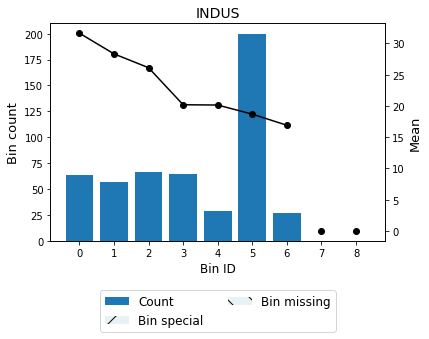

In [22]:
binning_table.plot()

In [23]:
optb.information()

optbinning (Version 0.17.2)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Name    : INDUS                           
  Status  : OPTIMAL                         

  Pre-binning statistics
    Number of pre-bins                    13
    Number of refinements                  0

  Solver statistics
    Type                                  cp
    Number of booleans                   100
    Number of branches                   200
    Number of conflicts                    0
    Objective value                 32723523
    Best objective bound            32723523

  Timing
    Total time                          0.23 sec
    Pre-processing                      0.00 sec   (  0.12%)
    Pre-binning                         0.00 sec   (  1.52%)
    Solver                              0.22 sec   ( 97.91%)
      model generation                  0.19 sec   ( 84.67%)
      optimizer                         0.03 sec   ( 15.33%)
    Post-processing                     0

In [24]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.51303567
    WoE                     77.78913838
    WoE (normalized)         3.45226144
    HHI                      0.22356231
    HHI (normalized)         0.12650760
    Quality score            0.02383215

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1     2.180865 3.118080e-02
        1      2     1.537968 1.267445e-01
        2      3     5.254539 7.781110e-07
        3      4     0.064736 9.485275e-01
        4      5     1.923770 5.601023e-02
        5      6     1.867339 6.563949e-02



A smoother curve, keeping the valley monotonicity, can be achieved by using ``monotonic_trend="convex"``.

In [25]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="convex")
optb.fit(x, y)

ContinuousOptimalBinning(monotonic_trend='convex', name='INDUS')

In [26]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 3.99)",92,0.181818,2932.6,8.688703,31.876087,16.5,50.0,0,9.343281,1.698778
1,"[3.99, 8.01)",125,0.247036,3092.3,6.644213,24.738400,14.4,50.0,0,2.205594,0.544860
2,"[8.01, 9.12)",33,0.065217,600.0,3.614571,18.181818,12.7,27.5,0,-4.350988,0.283760
3,"[9.12, 18.84)",199,0.393281,3610.8,7.540328,18.144724,5.0,50.0,0,-4.388083,1.725748
4,"[18.84, inf)",57,0.112648,1165.9,9.519086,20.454386,7.0,50.0,0,-2.078420,0.234130
5,Special,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
6,Missing,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
Totals,,506,1.000000,11401.6,,22.532806,5.0,50.0,0,67.431978,4.487277


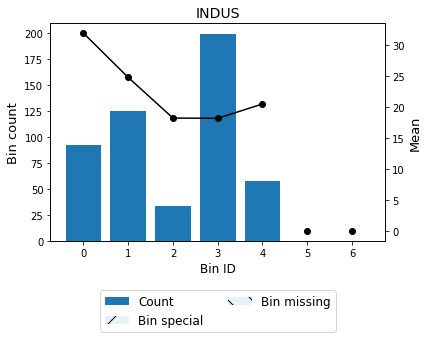

In [27]:
binning_table.plot()

In [28]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.48727679
    WoE                     67.43197816
    WoE (normalized)         2.99261340
    HHI                      0.26569701
    HHI (normalized)         0.14331318
    Quality score            0.01843250

  Monotonic trend       valley (convex)

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1     6.588254 5.789868e-10
        1      2     7.575550 2.331580e-11
        2      3     0.044930 9.642654e-01
        3      4    -1.686553 9.572501e-02



For example, we can force the variable INDUS (proportion of non-retail business acres per town) to be monotonically descending with respect to the house-pric and satisfy a max p-value constraint.

In [29]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="descending",
                                max_pvalue=0.05)
optb.fit(x, y)

ContinuousOptimalBinning(max_pvalue=0.05, monotonic_trend='descending',
                         name='INDUS')

In [30]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 3.35)",63,0.124506,1994.0,8.569841,31.650794,16.5,50.0,0,9.117987,1.135243
1,"[3.35, 5.04)",57,0.112648,1615.2,8.072710,28.336842,17.2,50.0,0,5.804036,0.653814
2,"[5.04, 8.01)",97,0.191700,2415.7,7.221288,24.904124,14.4,50.0,0,2.371317,0.454581
3,"[8.01, 20.73)",262,0.517787,4920.3,7.983667,18.779771,5.0,50.0,0,-3.753035,1.943271
4,"[20.73, inf)",27,0.053360,456.4,3.690878,16.903704,7.0,23.0,0,-5.629103,0.300367
5,Special,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
6,Missing,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
Totals,,506,1.000000,11401.6,,22.532806,5.0,50.0,0,71.741091,4.487277


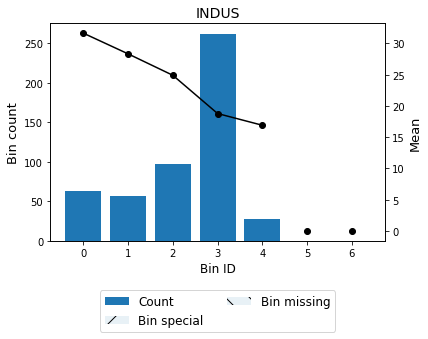

In [31]:
binning_table.plot()

In [32]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.48727679
    WoE                     71.74109110
    WoE (normalized)         3.18385070
    HHI                      0.33589027
    HHI (normalized)         0.22520531
    Quality score            0.49256380

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1     2.180865 3.118080e-02
        1      2     2.647685 9.326789e-03
        2      3     6.930572 6.470796e-11
        3      4     2.169454 3.432174e-02



#### Mininum mean difference between consecutive bins

Now, we note that the mean difference between consecutive bins is not significant enough. Therefore, we decide to set ``min_mean_diff=1.0``:

In [33]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="descending", min_mean_diff=1.0)
optb.fit(x, y)

ContinuousOptimalBinning(min_mean_diff=1.0, monotonic_trend='descending',
                         name='INDUS')

In [34]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 3.35)",63,0.124506,1994.0,8.569841,31.650794,16.5,50.0,0,9.117987,1.135243
1,"[3.35, 5.04)",57,0.112648,1615.2,8.072710,28.336842,17.2,50.0,0,5.804036,0.653814
2,"[5.04, 6.66)",66,0.130435,1723.7,7.879078,26.116667,16.0,50.0,0,3.583860,0.467460
3,"[6.66, 10.30)",93,0.183794,1876.1,4.029092,20.173118,12.7,35.2,0,-2.359688,0.433698
4,"[10.30, 20.73)",200,0.395257,3736.2,8.959305,18.681000,5.0,50.0,0,-3.851806,1.522453
5,"[20.73, inf)",27,0.053360,456.4,3.690878,16.903704,7.0,23.0,0,-5.629103,0.300367
6,Special,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
7,Missing,0,0.000000,0.0,NaN,0.000000,NaN,NaN,0,-22.532806,0.000000
Totals,,506,1.000000,11401.6,,22.532806,5.0,50.0,0,75.412093,4.513036


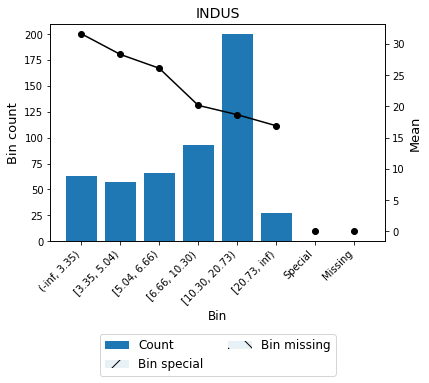

In [35]:
binning_table.plot(show_bin_labels=True)

In [36]:
binning_table.analysis()

-------------------------------------------------
OptimalBinning: Continuous Binning Table Analysis
-------------------------------------------------

  General metrics

    IV                       4.51303567
    WoE                     75.41209309
    WoE (normalized)         3.34676880
    HHI                      0.23806027
    HHI (normalized)         0.12921174
    Quality score            0.45843318

  Monotonic trend            descending

  Significance tests

    Bin A  Bin B  t-statistic      p-value
        0      1     2.180865 3.118080e-02
        1      2     1.537968 1.267445e-01
        2      3     5.628303 2.077284e-07
        3      4     1.966209 5.022562e-02
        4      5     1.867339 6.563949e-02



#### Handle outliers

Version 0.16.1 introduced the outlier detector ``YQuantileDetector``, specially designed to remove outliers for the ``ContinuousOptimalBinning`` algorithm. The application of this detector permits obtaining mean values per bin more similar to those obtained with more robust statistics (e.g., the median).

In [37]:
from optbinning.binning.outlier import YQuantileDetector

In [38]:
variable = "LSTAT"
x = df[variable].values

In [39]:
detector = YQuantileDetector(n_bins=10, outlier_detector="range",
                             outlier_params={'method': 'HDI'})
detector.fit(x, y)

YQuantileDetector(n_bins=10, outlier_detector='range',
                  outlier_params={'method': 'HDI'})

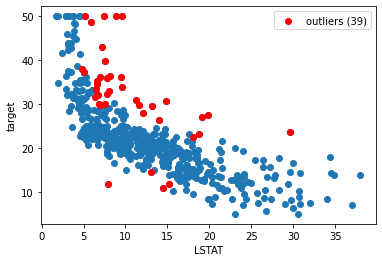

In [40]:
plt.scatter(x, y)

mask = detector.get_support()
plt.scatter(x[mask], y[mask], color='r', label=f"outliers ({np.count_nonzero(mask)})")

plt.xlabel(variable)
plt.ylabel("target")

plt.legend()
plt.show()

In [41]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="descending",
                                outlier_detector="yquantile",
                                outlier_params={
                                    'n_bins': 10,
                                    'outlier_detector': 'range',
                                    'outlier_params': {'method': 'HDI'}
                                },
                               verbose=True)
optb.fit(x, y)

2022-12-15 11:42:33,754 | INFO : Optimal binning started.
2022-12-15 11:42:33,757 | INFO : Options: check parameters.
2022-12-15 11:42:33,759 | INFO : Pre-processing started.
2022-12-15 11:42:33,770 | INFO : Pre-processing: number of samples: 506
2022-12-15 11:42:33,776 | INFO : Pre-processing: number of clean samples: 467
2022-12-15 11:42:33,778 | INFO : Pre-processing: number of missing samples: 0
2022-12-15 11:42:33,780 | INFO : Pre-processing: number of special samples: 0
2022-12-15 11:42:33,783 | INFO : Pre-processing: number of outlier samples: 39
2022-12-15 11:42:33,784 | INFO : Pre-processing terminated. Time: 0.0031s
2022-12-15 11:42:33,785 | INFO : Pre-binning started.
2022-12-15 11:42:33,791 | INFO : Pre-binning: number of prebins: 14
2022-12-15 11:42:33,792 | INFO : Pre-binning terminated. Time: 0.0047s
2022-12-15 11:42:33,793 | INFO : Optimizer started.
2022-12-15 11:42:33,794 | INFO : Optimizer: monotonic trend set to descending.
2022-12-15 11:42:33,797 | INFO : Optimizer

ContinuousOptimalBinning(monotonic_trend='descending', name='LSTAT',
                         outlier_detector='yquantile',
                         outlier_params={'n_bins': 10,
                                         'outlier_detector': 'range',
                                         'outlier_params': {'method': 'HDI'}},
                         verbose=True)

In [42]:
optb.binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 4.15)",36,0.077088,1495.8,7.729866,41.550000,24.8,50.0,0,19.824732,1.528245
1,"[4.15, 5.49)",39,0.083512,1218.2,6.428482,31.235897,21.9,50.0,0,9.510630,0.794250
2,"[5.49, 6.57)",29,0.062099,735.1,3.174426,25.348276,20.6,33.2,0,3.623008,0.224983
3,"[6.57, 7.68)",29,0.062099,705.8,2.035786,24.337931,20.7,29.1,0,2.612663,0.162242
4,"[7.68, 9.95)",59,0.126338,1341.0,3.012688,22.728814,16.5,30.3,0,1.003546,0.126786
5,"[9.95, 11.67)",42,0.089936,884.4,2.257068,21.057143,15.0,24.7,0,-0.668125,0.060088
6,"[11.67, 13.74)",49,0.104925,982.4,2.119503,20.048980,15.0,24.5,0,-1.676288,0.175885
7,"[13.74, 15.00)",28,0.059957,550.2,2.143012,19.650000,16.0,24.4,0,-2.075268,0.124427
8,"[15.00, 17.11)",37,0.079229,632.6,2.794830,17.097297,10.2,22.4,0,-4.627970,0.366670
9,"[17.11, 18.93)",38,0.081370,607.3,2.970810,15.981579,9.6,23.1,0,-5.743689,0.467367


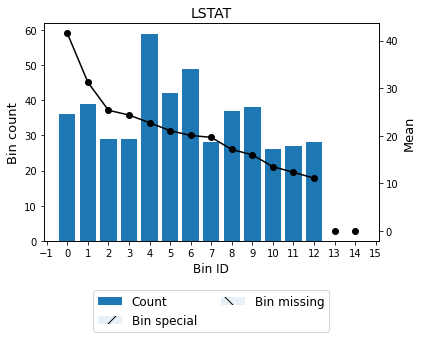

In [43]:
optb.binning_table.plot()

As observed in the logs, 39 outliers were removed during preprocessing. Compared to the standard binning, the resulting binning after removing outliers returns more bins (13 vs 10) and higher objective function (total WoE).

#### Sample weights

Finally, version 0.17.0 added support to sample weights. As an example, let's increase the weights for values < 10.

In [44]:
sample_weight = np.ones(len(x))
sample_weight[x < 10] = 5

In [45]:
optb = ContinuousOptimalBinning(name=variable, dtype="numerical",
                                monotonic_trend="descending")
optb.fit(x, y, sample_weight=sample_weight)

ContinuousOptimalBinning(monotonic_trend='descending', name='LSTAT')

In [46]:
optb.binning_table.build()

,Bin,Count,Count (%),Sum,Std,Mean,Min,Max,Zeros count,WoE,IV
0,"(-inf, 4.15)",180,0.130246,7479.0,84.878526,41.550000,124.0,250.0,0,14.617149,1.903825
1,"[4.15, 5.15)",155,0.112156,5135.0,68.222852,33.129032,112.5,250.0,0,6.196181,0.694941
2,"[5.15, 6.06)",140,0.101302,3850.5,56.552267,27.503571,103.0,244.0,0,0.570720,0.057815
3,"[6.06, 6.87)",140,0.101302,3674.0,53.287277,26.242857,103.5,176.0,0,-0.689994,0.069898
4,"[6.87, 8.85)",285,0.206223,7275.0,53.081171,25.526316,59.5,250.0,0,-1.406535,0.290060
5,"[8.85, 9.95)",185,0.133864,4663.0,52.840208,25.205405,93.5,250.0,0,-1.727446,0.231243
6,"[9.95, 11.67)",52,0.037627,1103.6,17.592652,21.223077,15.0,101.5,0,-5.709774,0.214840
7,"[11.67, 14.40)",67,0.048480,1364.9,2.652276,20.371642,14.5,29.6,0,-6.561209,0.318090
8,"[14.40, 17.24)",60,0.043415,1037.5,3.588003,17.291667,10.2,30.7,0,-9.641184,0.418575
9,"[17.24, 19.90)",43,0.031114,714.3,4.032554,16.611628,8.3,27.5,0,-10.321223,0.321138


Note the count increase in the first bins.

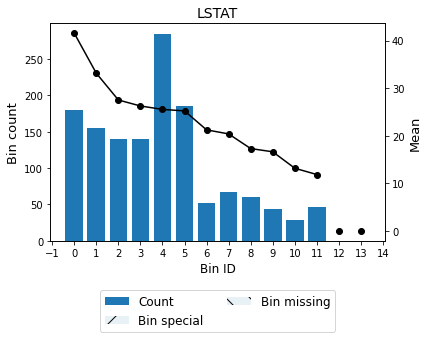

In [47]:
optb.binning_table.plot()